In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

#ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [ ]:
class LSTMModel:
    def __init__(self, input, time_step=30, epochs=20, batch_size=32, metrics=['accuracy']):
        self.params = {"epochs": epochs, "batch_size": batch_size, "metrics": metrics}
        self.model = None
        self.history = None
        self.input_shape = input

    def make_model(self):
        model = Sequential()
        model.add(LSTM(4, input_shape=self.input_shape))
        model.add(Dense(1))
        model.compile(loss='mean_squared_error', optimizer='adam')
    
    def fit(self):
        self.history = model.fit(trainX, trainY, validation_split=0.33,
                                 epochs=self.params["epochs"], batch_size=self.params["batch_size"])


    def predict(self, X):
        return self.model.predict(X)

In [ ]:
# Load Data
df = pd.read_csv("../data/complete-merged-df.csv", index_col=0, parse_dates=True)
df.head()

In [ ]:
# convert an array of values into a dataset matrix

def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - look_back - 1):
        a = dataset[i:(i + look_back), 1:]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

In [ ]:
dataset = df.values

# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

# split into train and test sets
train_size = int(len(dataset) * 0.75) 
test_size = len(dataset) - train_size
train, test = dataset[:train_size, :], dataset[train_size:len(dataset), :]

In [ ]:
look_back = 30
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

# reshape input to be  [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], look_back, 14))
testX = np.reshape(testX, (testX.shape[0], look_back, 14))


In [ ]:
# create and fit the LSTM network
input = (trainX.shape[1], trainX.shape[2])
trainX.shape, trainY.shape, input

In [451]:
model = Sequential()

model.add(LSTM(64, activation='tanh' ,input_shape=input))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.summary()

Model: "sequential_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_23 (LSTM)               (None, 64)                20224     
_________________________________________________________________
dense_15 (Dense)             (None, 1)                 65        
Total params: 20,289
Trainable params: 20,289
Non-trainable params: 0
_________________________________________________________________


In [452]:
history = model.fit(trainX, trainY, validation_split=0.4, epochs=20, batch_size=32)

Epoch 1/20
26/26 [==============================] - 1s 56ms/step - loss: 0.0026 - val_loss: 0.0068
Epoch 2/20
26/26 [==============================] - 1s 21ms/step - loss: 4.8248e-04 - val_loss: 0.0027
Epoch 3/20
26/26 [==============================] - 1s 20ms/step - loss: 3.1041e-04 - val_loss: 0.0012
Epoch 4/20
26/26 [==============================] - 1s 22ms/step - loss: 2.7859e-04 - val_loss: 0.0012
Epoch 5/20
26/26 [==============================] - 1s 21ms/step - loss: 2.5594e-04 - val_loss: 7.4104e-04
Epoch 6/20
26/26 [==============================] - 1s 20ms/step - loss: 2.4712e-04 - val_loss: 5.1083e-04
Epoch 7/20
26/26 [==============================] - 1s 20ms/step - loss: 2.6628e-04 - val_loss: 4.7226e-04
Epoch 8/20
26/26 [==============================] - 1s 21ms/step - loss: 2.4737e-04 - val_loss: 0.0011
Epoch 9/20
26/26 [==============================] - 1s 21ms/step - loss: 2.5565e-04 - val_loss: 3.9604e-04
Epoch 10/20
26/26 [==============================] - 1s 22ms/

In [446]:
def plot_history(history):
    plt.figure(figsize=(8,6))
    plt.plot(history.history['loss'], label='train')
    plt.plot(history.history['val_loss'], label='test')
    plt.legend()
    plt.show()

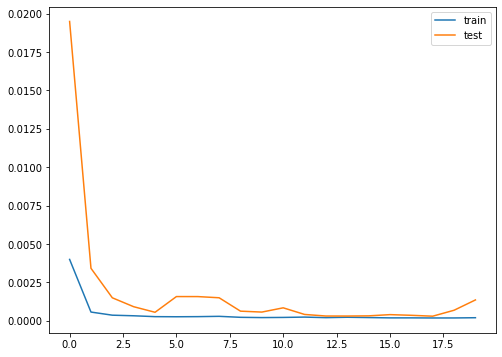

In [447]:
# Plot training
plot_history(history)

In [360]:
def inverse_transform(X, scaler):
    # Get something which has as many features as dataset
    extended = np.zeros((len(X), 15))
    # Put the predictions there
    extended[:, 0:] = X
    # Inverse transform it and select the 3rd column.
    return scaler.inverse_transform(extended)[:,0]


In [453]:
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

In [454]:
inv_train_yhat = inverse_transform(trainPredict, scaler)
inv_test_yhat = inverse_transform(testPredict, scaler)

In [387]:
pred = pd.DataFrame(columns=['actual', 'prediction'])
pred['actual'] = df[-len(inv_test_yhat):].close.values
pred['prediction'] = inv_test_yhat

In [388]:
pred.tail(10)

,actual,prediction
416,48610.619112,23949.315283
417,50807.000000,23659.052074
418,50834.300000,23784.111006
419,50430.073507,24006.115385
420,50792.036921,24229.644145
421,50696.802160,25897.830230
422,47535.309698,26598.631491
423,46471.230000,26044.411588
424,47128.468155,25725.000069
425,46208.210437,25191.735428


In [323]:
# Accuracy metrics
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    corr = np.corrcoef(forecast, actual)[0, 1]   # corr
    mins = np.amin(np.hstack([forecast[:, None],
                              actual[:, None]]), axis=1)
    maxs = np.amax(np.hstack([forecast[:, None],
                              actual[:, None]]), axis=1)
    minmax = 1 - np.mean(mins/maxs)             # minmax

    return({'mape': str(round(mape*100, 3))+"%", 'me': me, 'mae': mae,
            'mpe': mpe, 'rmse': rmse,
            'corr': corr, 'minmax': minmax})

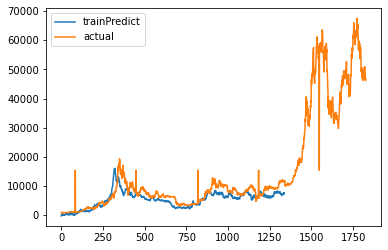

In [389]:
plt.plot(inv_train_yhat)
plt.plot(df.close.values)
plt.legend(['trainPredict', 'actual'])

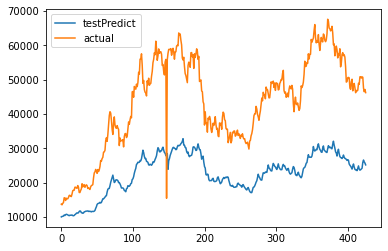

In [390]:
plt.plot(inv_test_yhat)
plt.plot(df[-len(inv_test_yhat):].close.values)
plt.legend(['testPredict', 'actual'])

In [366]:
print(forecast_accuracy(inv_train_yhat, df[:len(inv_train_yhat)].close.values))
print(forecast_accuracy(inv_test_yhat, df[-len(inv_test_yhat):].close.values))

{'mape': '21.888%', 'me': -45.18938194665065, 'mae': 1303.4970860135993, 'mpe': 0.07003255153390622, 'rmse': 1922.346926919394, 'corr': 0.8321812789956786, 'minmax': 0.17401615859685537}
{'mape': '35.588%', 'me': -15698.14737830374, 'mae': 15787.716180388505, 'mpe': -0.3500899387913305, 'rmse': 17192.123185157994, 'corr': 0.9209637247477643, 'minmax': 0.3542809998941455}


In [391]:
model2 = Sequential()
model2.add(LSTM(units=128, activation='tanh', return_sequences=True,
               input_shape=input))
model2.add(Dropout(0.2))
model2.add(LSTM(units=128, activation='tanh', return_sequences=True))
model2.add(Dropout(0.2))
model2.add(LSTM(units=128, activation='tanh', return_sequences=False))
model2.add(Dropout(0.2))
model2.add(Dense(units=1))  # Prediction of the next value

model2.compile(optimizer='adam', loss='mean_squared_error')
model2.summary()

Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_20 (LSTM)               (None, 30, 128)           73216     
_________________________________________________________________
dropout_3 (Dropout)          (None, 30, 128)           0         
_________________________________________________________________
lstm_21 (LSTM)               (None, 30, 128)           131584    
_________________________________________________________________
dropout_4 (Dropout)          (None, 30, 128)           0         
_________________________________________________________________
lstm_22 (LSTM)               (None, 128)               131584    
_________________________________________________________________
dropout_5 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_14 (Dense)             (None, 1)               

In [392]:
history2 = model2.fit(trainX, trainY, validation_split=0.3, epochs=20, batch_size=64)

Epoch 1/20
15/15 [==============================] - 5s 330ms/step - loss: 0.0084 - val_loss: 0.0014
Epoch 2/20
15/15 [==============================] - 3s 167ms/step - loss: 0.0012 - val_loss: 7.9913e-04
Epoch 3/20
15/15 [==============================] - 2s 167ms/step - loss: 5.6629e-04 - val_loss: 4.1195e-04
Epoch 4/20
15/15 [==============================] - 3s 172ms/step - loss: 4.8811e-04 - val_loss: 0.0011
Epoch 5/20
15/15 [==============================] - 3s 172ms/step - loss: 4.0254e-04 - val_loss: 0.0015
Epoch 6/20
15/15 [==============================] - 3s 174ms/step - loss: 3.9892e-04 - val_loss: 0.0010
Epoch 7/20
15/15 [==============================] - 3s 170ms/step - loss: 3.8798e-04 - val_loss: 0.0015
Epoch 8/20
15/15 [==============================] - 3s 175ms/step - loss: 3.7509e-04 - val_loss: 0.0018
Epoch 9/20
15/15 [==============================] - 3s 177ms/step - loss: 3.6263e-04 - val_loss: 0.0020
Epoch 10/20
15/15 [==============================] - 3s 179ms/st

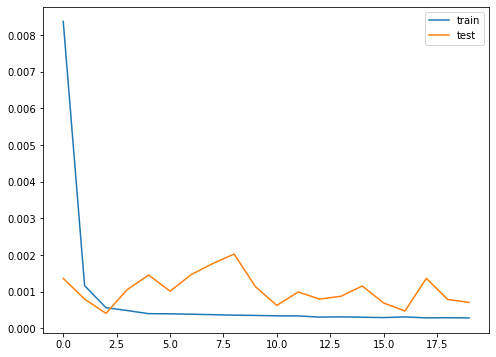

In [450]:
plot_history(history2)

In [394]:
# make predictions
trainPredict2 = model2.predict(trainX)
testPredict2 = model2.predict(testX)

In [395]:
inv_train_yhat2 = inverse_transform(trainPredict2, scaler)
inv_test_yhat2 = inverse_transform(testPredict2, scaler)

print(forecast_accuracy(inv_train_yhat2, df[:len(inv_train_yhat2)].close.values))
print(forecast_accuracy(inv_test_yhat2, df[-len(inv_test_yhat2):].close.values))

{'mape': '26.073%', 'me': 705.9970645492396, 'mae': 1499.2554365897845, 'mpe': 0.1804320642469236, 'rmse': 2109.7537663885237, 'corr': 0.8326542952182504, 'minmax': 0.1883325270990801}
{'mape': '33.446%', 'me': -15812.079307219785, 'mae': 15897.017346816172, 'mpe': -0.32898480914681383, 'rmse': 18009.48484266402, 'corr': 0.9180436972430003, 'minmax': 0.3330395688386003}


In [442]:
def plot_predictions(predictions, actual):
    pred_df = pd.DataFrame()
    pred_df['Actual'] = actual

    plt.figure(figsize=(12, 8))
    for idx, prediction in enumerate(predictions):
        plt.plot(prediction, label=f'Prediction-{idx+1}')
        pred_df[f'Prediction-{idx+1}'] = prediction

    print(pred_df)
    plt.plot(actual, label='Actual')
    plt.legend()
    plt.show()

    return pred_df


           Actual  Prediction-1  Prediction-2
0    13765.144079   9919.321891  13621.967356
1    13573.000000  10017.750924  13600.837965
2    14025.929379  10022.743967  13587.726498
3    14163.302878   9939.484116  13548.695582
4    15605.181292  10585.920105  13585.273758
..            ...           ...           ...
421  50696.802160  26012.212525  30184.721522
422  47535.309698  26037.048391  30293.302812
423  46471.230000  26175.488441  30418.755774
424  47128.468155  26113.333105  30530.143039
425  46208.210437  25802.236028  30621.613850

[426 rows x 3 columns]


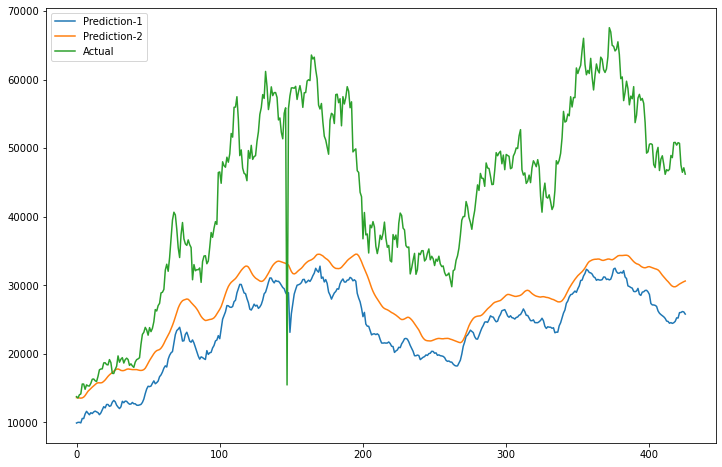

,Actual,Prediction-1,Prediction-2
0,13765.144079,9919.321891,13621.967356
1,13573.000000,10017.750924,13600.837965
2,14025.929379,10022.743967,13587.726498
3,14163.302878,9939.484116,13548.695582
4,15605.181292,10585.920105,13585.273758
...,...,...,...
421,50696.802160,26012.212525,30184.721522
422,47535.309698,26037.048391,30293.302812
423,46471.230000,26175.488441,30418.755774
424,47128.468155,26113.333105,30530.143039


In [455]:
plot_predictions([inv_test_yhat, inv_test_yhat2], df[-len(inv_test_yhat):].close.values)